# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd /Users/rushikesh/python_files/vscode/transformer/src/main/python/

/Users/rushikesh/python_files/vscode/transformer/src/main/python


In [3]:
import torch
import numpy as np
import pandas as pd

loss_fn = torch.nn.CrossEntropyLoss()

from utils.Embeddings.Embeddings import Embeddings
from utils.Attention.Attention import attentionLayer
from utils.Attention.Attention import multiHeads
from utils.Attention.Attention import residualConnection
from utils.FFN.FFN import feedForward
from utils.Tokenizer.Tokenizer import SimpleTokenizer



# Data

In [4]:
with open("data/Text.txt", 'r') as f:
    text = f.read()

In [5]:
words = text.lower().split(" ")

In [6]:
import re

def clean_words(word_list):
    cleaned = []
    for word in word_list:
        word_lower = word.lower()  # convert to lowercase
        if re.fullmatch(r"[a-z]+", word_lower) and (len(word_lower) >=4) and (len(word_lower) <= 8) :
            cleaned.append(word_lower)
    return cleaned


In [7]:
words = clean_words(words)

In [8]:
import random

def prepare_training_example(word, tokenizer, max_len=8, mask_prob=0.5):
   
    padded_word = list(word) + ['<e>' for i in range(max_len - len(word))]
    
    x_chars = padded_word[::]

    for i in range(len(x_chars)):
        if x_chars[i] != '<e>' and (x_chars[i] != '<s>') and random.random() < mask_prob:
            x_chars[i] = '<mask>'
    
    x_encoded = tokenizer.encode(x_chars, pad=True)
    y_encoded = tokenizer.encode(list(padded_word), pad=True)
    
    return x_encoded, y_encoded


In [9]:
## each char is a 
sequence   = 'mango'

Tokenizer  = SimpleTokenizer(list('abcdefghijklmnopqrstuvwxyz'))

x          = Tokenizer.encode(sequence, pad = True)



In [10]:
import random

X, Y = [], []

for word in words:
    # Choose a random mask probability for this example
    # mask_prob = random.uniform(0.1, 0.8)  # e.g., 10% to 80% masked
    u = random.random()
    mask_prob = 0.1 + (0.8 - 0.1) * (1 - u**2)  # favor smaller mask fraction
    
    x, y = prepare_training_example(word, Tokenizer, max_len=8, mask_prob=mask_prob)
    
    X.append(x)
    Y.append(y)


In [11]:
len(X), len(Y)

(96634, 96634)

In [12]:
X[100], Y[100]

(tensor([[ 0, 19, 28, 28, 28, 28, 27, 27, 27, 27]]),
 tensor([[ 0, 19, 13,  1, 12, 12, 27, 27, 27, 27]]))

In [13]:
i = random.randint(1, len(X))

Tokenizer.decode(X[i]), Tokenizer.decode(Y[i])

('<s>sites<e><e><e><e>', '<s>sites<e><e><e><e>')

# Model

In [48]:
seq_len    = 10
vocab_size = 29
d_model    = 4 ## d_model should be even for positiona encodings to work

## emb is embeddings class which takes the encoded sequence as the input and returns the (token + pos) encodings
emb        = Embeddings(vocab_size = vocab_size, d_model= d_model, max_len= seq_len)
multiHeadLayer = multiHeads(num_heads = 2, 
                            d_model   = d_model, 
                            max_len   = seq_len)
rc = residualConnection()
FFN = feedForward(d_model = 4, max_len = seq_len, vocab_size = vocab_size)

x = X_tensor[:2]
y = Y_tensor[:2]

x0    = emb(x).squeeze(1)

x1 = multiHeadLayer(x0)

x2 = rc(x0, x1)

x3  = FFN(x2)

# ----- LOSS -----
logits  = x3
targets = y       

loss = loss_fn(
    logits.view(-1, logits.size(-1)),   # (B*T, V)
    targets.view(-1)                    # (B*T)
)

loss.backward()

TypeError: unsupported operand type(s) for +: 'Tensor' and 'list'

In [49]:
x0.shape, x1[0].shape, x1[1].shape

(torch.Size([2, 10, 4]), torch.Size([2, 10, 2, 2]), torch.Size([2, 10, 2, 2]))

In [50]:
torch.cat(x1, dim =-1)

tensor([[[[ 0.8995,  2.4040,  0.7600,  0.8333],
          [ 0.8597,  2.4778,  0.0523,  1.0155]],

         [[ 0.7245,  2.8062,  0.1508,  0.8589],
          [ 0.6702,  2.7697,  0.4310,  0.6287]],

         [[ 0.8540,  0.1637, -0.4333,  1.0751],
          [ 0.8452,  1.3122, -0.8051,  0.8752]],

         [[ 0.7245,  2.8062,  0.1508,  0.8589],
          [ 0.6702,  2.7697,  0.4310,  0.6287]],

         [[ 1.4202,  0.9472, -1.5265,  1.3627],
          [ 1.4192,  1.0901, -1.5571,  1.3462]],

         [[ 0.7245,  2.8062,  0.1508,  0.8589],
          [ 0.6702,  2.7697,  0.4310,  0.6287]],

         [[ 0.6857,  3.6490,  0.1900,  1.2002],
          [ 0.6748,  3.6062,  0.1566,  1.5393]],

         [[ 0.6857,  3.6490,  0.1900,  1.2002],
          [ 0.6748,  3.6062,  0.1566,  1.5393]],

         [[ 0.6857,  3.6490,  0.1900,  1.2002],
          [ 0.6748,  3.6062,  0.1566,  1.5393]],

         [[ 0.6857,  3.6490,  0.1900,  1.2002],
          [ 0.6748,  3.6062,  0.1566,  1.5393]]],


        [[[ 0.8995

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# --- Hyperparameters ---
seq_len    = 8
vocab_size = 29
d_model    = 8
num_epochs = 5000
learning_rate = 0.001

# --- Assume these are your prepared training examples ---
# X: list of tensors (B, T)
# Y: list of tensors (B, T)
# Convert to tensors
X_tensor = torch.stack(X)  # shape: (B, T)
Y_tensor = torch.stack(Y)  # shape: (B, T)

# --- Loss and optimizer ---
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(emb.parameters() +
                    #    multiHeadLayer.parameters() +
                       FFN.parameters(),
                       lr=learning_rate)


In [25]:

# --- Training loop ---
loss_history = []

for epoch in range(num_epochs):
    optimizer.zero_grad()

    idx  = random.sample(range(len(words)), 5000)

    X_idx = X_tensor[idx].squeeze(1)
    Y_idx = Y_tensor[idx].squeeze(1)

    
    # Forward pass
    x0 = emb(X_idx)
    x1 = multiHeadLayer(x0)
    x2 = rc(x0, x1)
    x3 = FFN(x2)
    
    logits = x3
    targets = Y_idx
    
    # Compute loss
    loss = loss_fn(
        logits.view(-1, logits.size(-1)),  # (B*T, V)
        targets.view(-1)                    # (B*T)
    )
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# --- Plot loss ---
plt.figure(figsize=(8,5))
plt.plot(loss_history, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


AttributeError: 'attentionLayer' object has no attribute 'head_dim'

In [22]:
print("X:", X_tensor.squeeze(1).shape)
x0 = emb(X_tensor.squeeze(1)[:2])
print("x0:", x0.shape)
x1 = multiHeadLayer(x0)
print("x1:", x1.shape)
x2 = rc(x0, x1)
print("x2:", x2.shape)
x3 = FFN(x2)
print("x3:", x3.shape)


X: torch.Size([96634, 10])
x0: torch.Size([2, 10, 4])
x1: torch.Size([2, 10, 4])
x2: torch.Size([2, 10, 4])
x3: torch.Size([2, 10, 29])


In [26]:
print("grad emb:", emb.emb.grad.abs().mean())


grad emb: tensor(33.5983)


In [55]:
x = X_tensor[0]
y = X_tensor[0]

x0    = emb(x)

x1 = multiHeadLayer(x0)

x2 = rc(x0, x1)

x3  = FFN(x2)

Tokenizer.decode(x3.argmax(dim = 2))


'esrlsspvvv'

In [59]:
X_tensor[[1,2]]

tensor([[[ 0, 28, 28, 19, 28, 27, 27, 27, 27, 27]],

        [[ 0, 28, 28,  6, 28, 18,  5, 27, 27, 27]]])

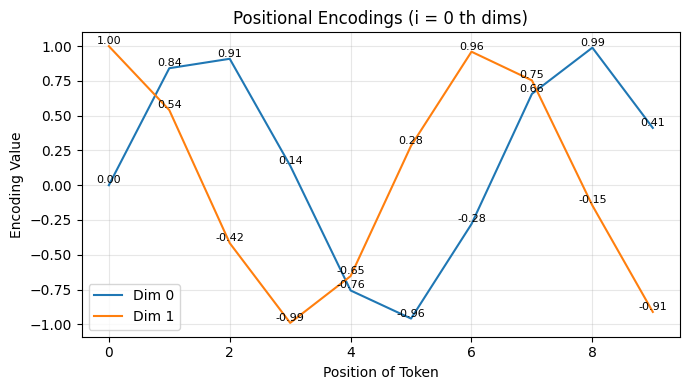

a = 1, b = 2 (Token positions)
sin(a+b) = sin(a).cos(b) + cos(a).sin(b)

sin(a) = 0.8414709568023682
cos(a) = 0.5403023362159729
sin(b) = 0.9092974066734314
cos(b) = -0.416146844625473

sin(1).cos(2) + cos(1).sin(2) = 0.141120046377182; 
sin(3) == 0.14112000167369843

Explaination: 

              
        This property means that for any fixed offset B, the positional encoding of A+B can be obtained by applying a fixed linear transformation (a rotation) to the positional encoding of A.

        This is crucial for the self-attention mechanism. The attention score between a query at position q and a key at position k is based on a dot product. Because of this linear property, the dot product between their positional encodings, PE(q)T
        
        PE(k), depends only on the relative position q-k, not their absolute positions. This allows the model to easily learn how to attend to tokens that are a certain distance away, regardless of where they are in the sequence.
                


In [182]:
## plot positional encodings to understand 

emb.plot_positional_encodings()

In [49]:
x, x0, x1

(tensor([[ 0, 13,  1, 14,  7, 15, 27]]),
 tensor([[[ 8.6756e-01,  1.0816e+00,  7.1975e-01,  9.3561e-01],
          [-4.4384e-01,  1.5954e-01, -6.9216e-01,  2.0710e+00],
          [ 3.8863e-01,  1.8227e-01,  4.0648e-01,  6.7202e-01],
          [ 1.1753e-01, -1.5447e+00, -1.0107e-01,  1.0070e+00],
          [-1.5156e+00, -4.2770e-02, -4.8777e-01,  8.2020e-02],
          [-1.2006e+00, -6.9961e-04,  6.2525e-01,  1.0465e+00],
          [-4.8468e-01, -1.0895e-01, -7.7397e-01,  3.6663e-01]]]),
 tensor([[[ 0.1234, -0.0880,  0.4689, -0.5033],
          [ 0.3647,  1.7996, -0.7440, -0.4848],
          [ 0.3991, -0.3661, -0.2162, -0.1554],
          [ 0.8997, -0.8695, -0.8934,  0.0023],
          [ 0.3688, -0.5472, -0.2859,  0.0026],
          [ 0.1878,  0.1927, -0.2613, -0.0743],
          [ 0.4465, -0.6552, -0.2903, -0.0454]]]))

In [50]:
emb.pos_emb.shape

torch.Size([7, 4])

In [51]:
emb.pos_emb[:5, :]

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0100,  0.9999],
        [ 0.9093, -0.4161,  0.0200,  0.9998],
        [ 0.1411, -0.9900,  0.0300,  0.9996],
        [-0.7568, -0.6536,  0.0400,  0.9992]])

In [52]:
x.shape, x0.shape, x1.shape

(torch.Size([1, 7]), torch.Size([1, 7, 4]), torch.Size([1, 7, 4]))

In [54]:
rc(x0, x1)

tensor([[[ 0.9909,  0.9936,  1.1887,  0.4323],
         [-0.0792,  1.9591, -1.4362,  1.5862],
         [ 0.7877, -0.1838,  0.1903,  0.5166],
         [ 1.0172, -2.4142, -0.9945,  1.0093],
         [-1.1467, -0.5899, -0.7736,  0.0847],
         [-1.0128,  0.1920,  0.3639,  0.9722],
         [-0.0382, -0.7642, -1.0643,  0.3212]]])

In [56]:
x1

tensor([[[ 0.5288, -0.5870, -1.1265, -0.6774],
         [ 0.7480, -1.8877, -1.2009, -0.6571],
         [ 0.7951, -0.4721, -1.0061, -0.7632],
         [ 2.8988,  0.0375, -1.0699, -1.0097],
         [ 0.4701, -1.3669, -0.9741, -1.1076],
         [ 0.8275, -0.9136, -0.9920, -0.9337],
         [ 0.4815, -1.0118, -0.9404, -0.7645]]])

In [58]:
rc(x0, x1)

tensor([[[ 1.3964e+00,  4.9461e-01, -4.0678e-01,  2.5820e-01],
         [ 3.0419e-01, -1.7282e+00, -1.8931e+00,  1.4139e+00],
         [ 1.1837e+00, -2.8983e-01, -5.9959e-01, -9.1214e-02],
         [ 3.0163e+00, -1.5072e+00, -1.1709e+00, -2.6515e-03],
         [-1.0455e+00, -1.4096e+00, -1.4619e+00, -1.0256e+00],
         [-3.7309e-01, -9.1427e-01, -3.6671e-01,  1.1282e-01],
         [-3.2058e-03, -1.1207e+00, -1.7144e+00, -3.9789e-01]]])

In [60]:
x2.shape

torch.Size([1, 7, 4])

In [61]:
x3.shape

torch.Size([1, 7, 28])

In [62]:
x3.sum(dim = 2)

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]])

'tdtt<s>cd'